In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('recons-sab-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAAGTCGGAGGAGCAAGCGCG...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGAGCGCCATTTTGTTAC...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 78253.40it/s]


[11, 41, 49, 52, 59, 66, 81, 90, 93, 102, 116, 130, 133, 151, 165, 173, 188, 196, 190, 221, 249, 259, 281, 277, 314, 338, 333, 352, 359, 391, 398, 400, 405, 450, 454, 496, 482, 510, 537, 556, 574, 571, 598, 605, 640, 647, 652, 698, 696, 725, 754, 755, 765, 813, 807, 1466, 1430, 1431, 1403, 1394, 1380, 1371, 1360, 1340, 1335, 1310, 1254, 1302, 1277, 1247, 1259, 1203, 1199, 1186, 1197, 1173, 1127, 1123, 1141, 1092, 1117, 1077, 1074, 1058, 1041, 1028, 996, 995, 1005, 952, 964, 944, 946, 920, 916, 912, 896, 876, 879, 838, 833, 853, 895, 837, 821, 840, 863, 852, 782, 570]


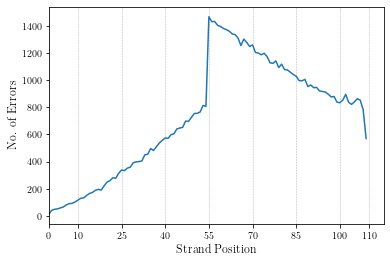

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov5-sab-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:03<00:00, 2869.04it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> GAA 6
G -> AC 6
C -> AA 6
CT -> AG 6
T -> CC 6
TT -> A 6
 -> CCC 6
GTT ->  6
TTG ->  6
CC -> A 7
T -> CA 7
 -> ACA 7
TGT ->  8
CA ->  8
G -> AA 8
T -> AC 8
G -> CA 8
GG ->  9
CT -> A 9
T -> GG 10
TC -> A 11
TG -> A 11
T -> AA 12
GT -> A 12
TG -> C 14
CC ->  15
 -> GT 16
AC ->  16
GA ->  17
TA ->  18
 -> TG 19
AG ->  20
 -> CT 21
 -> CG 22
 -> TT 22
 -> GA 22
A -> G 23
 -> AT 24
TT ->  24
 -> GG 25
A -> T 25
G -> T 26
 -> TC 27
 -> AC 27
CG ->  28
 -> AG 28
 -> GC 28
AT ->  29
GC ->  30
 -> TA 31
CT ->  32
 -> CA 32
C -> T 33
 -> CC 35
C -> G 37
A -> C 38
TC ->  39
TG ->  43
 -> AA 44
GT ->  62
G -> C 217
G -> A 221
T -> G 223
C -> A 254
T -> A 282
T -> C 289
A ->  359
 -> T 467
 -> G 575
C ->  606
 -> C 729
G ->  756
 -> A 842
T ->  1089


G ->  @ 67 6
C ->  @ 39 6
 -> A @ 76 6
G ->  @ 78 6
T ->  @ 9 6
T ->  @ 62 6
C -> A @ 52 6
C -> A @ 55 6
C ->  @ 25 6
T -> C @ 70 6
G ->  @ 79 6
T ->  @ 74 6
 -> CT @ 54 6
 -> A @ 92 6
C ->  @ 108 6
 -> C @ 59 6
 -> A @ 94 6
C -> A @ 65 6
C ->  @ 13 6
 -> C @ 79 6
T -> C @ 61 6
T ->  @ 84 6
G ->  @ 73 6
 -> AG @ 55 6
T -> C @ 84 6
T ->  @ 86 6
G ->  @ 69 6
T ->  @ 60 6
T -> A @ 33 6
G -> C @ 50 6
 -> A @ 42 6
C ->  @ 68 6
T -> A @ 41 6
T -> G @ 64 6
 -> A @ 34 6
T ->  @ 18 6
 -> GG @ 54 6
 -> A @ 72 6
T -> A @ 38 6
G -> C @ 56 6
C ->  @ 75 6
C ->  @ 80 6
T -> A @ 49 6
G ->  @ 20 6
T -> A @ 55 6
G ->  @ 19 6
G -> C @ 61 6
G ->  @ 15 6
 -> A @ 32 6
C ->  @ 59 6
T -> A @ 50 6
T ->  @ 26 6
T -> A @ 57 6
G -> C @ 71 6
C ->  @ 58 6
T ->  @ 37 6
 -> G @ 51 6
T -> A @ 62 6
C ->  @ 50 6
G ->  @ 38 6
T -> A @ 56 6
T ->  @ 31 6
C ->  @ 53 6
T -> A @ 59 6
C ->  @ 52 6
G -> A @ 50 7
C -> G @ 110 7
T -> A @ 53 7
G ->  @ 92 7
G ->  @ 95 7
T ->  @ 82 7
T ->  @ 72 7
T ->  @ 79 7
T ->  @ 70 7
T ->  @ 67

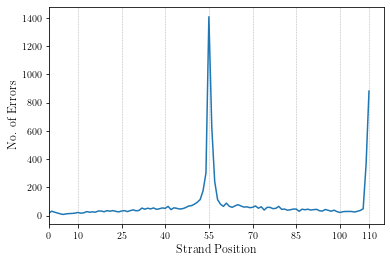

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov5-sab-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 12, 4, 3, 4, 2, 4, 5, 2, 6, 4, 4, 5, 7, 5, 1, 4, 4, 6, 5, 13, 4, 7, 5, 3, 5, 6, 8, 3, 7, 4, 6, 2, 3, 10, 7, 9, 6, 8, 8, 8, 8, 4, 4, 10, 8, 5, 7, 8, 10, 5, 11, 10, 9, 12, 43, 88, 26, 12, 2, 6, 9, 6, 3, 9, 8, 7, 7, 9, 5, 7, 13, 7, 10, 6, 4, 4, 5, 13, 7, 4, 10, 7, 5, 6, 11, 6, 7, 2, 4, 11, 2, 7, 5, 4, 3, 7, 4, 9, 8, 8, 4, 3, 3, 5, 2, 5, 5, 5, 31, 250]
[8, 2, 0, 0, 1, 0, 0, 1, 1, 3, 2, 0, 0, 3, 2, 3, 4, 3, 3, 0, 3, 0, 4, 2, 4, 1, 3, 1, 2, 3, 1, 0, 6, 3, 6, 3, 5, 4, 1, 4, 2, 1, 6, 4, 2, 2, 5, 4, 8, 7, 10, 9, 17, 26, 33, 265, 42, 14, 7, 4, 3, 4, 3, 7, 5, 4, 3, 5, 7, 7, 0, 5, 6, 5, 3, 4, 6, 2, 2, 5, 3, 3, 2, 1, 1, 1, 2, 4, 3, 5, 2, 1, 6, 3, 6, 1, 2, 2, 2, 1, 0, 4, 3, 0, 5, 0, 2, 5, 11, 89, 26]
[0, 3, 3, 4, 2, 2, 3, 2, 1, 0, 2, 2, 1, 2, 1, 6, 3, 0, 2, 6, 6, 5, 1, 4, 4, 0, 4, 3, 4, 3, 5, 3, 4, 4, 2, 10, 4, 3, 6, 5, 4, 5, 5, 4, 4, 1, 5, 4, 5, 5, 2, 5, 8, 7, 13, 30, 82, 28, 12, 7, 9, 10, 8, 3, 3, 7, 9, 6, 1, 6, 3, 5, 3, 6, 3, 7, 3, 2, 6, 6, 7, 3, 2, 3, 3, 3, 3, 8, 3, 2, 3, 5, 7, 2, 0, 7, 8, 1

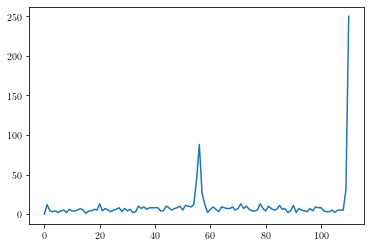

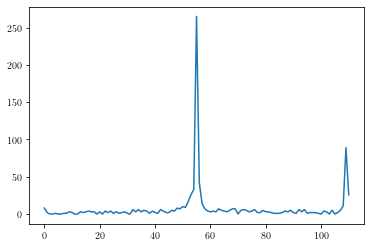

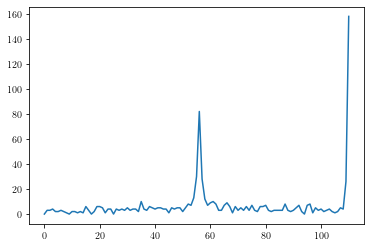

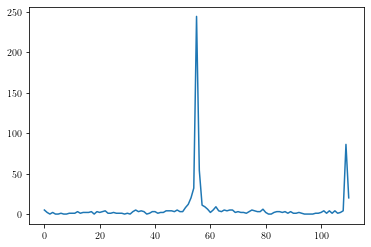

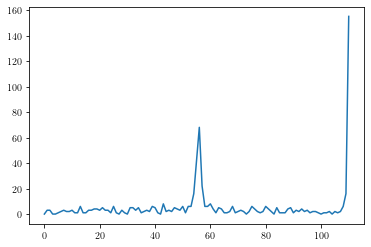

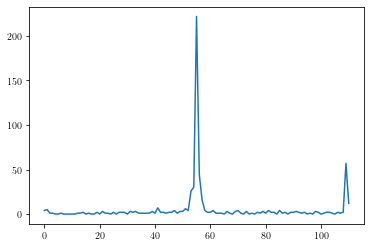

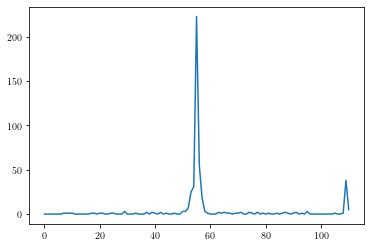

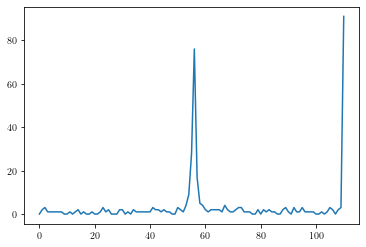

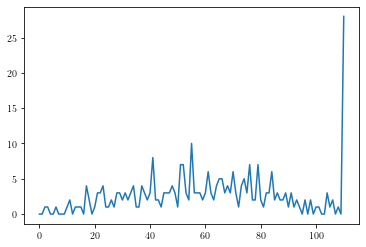

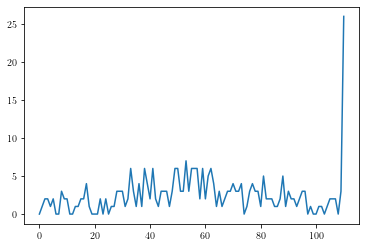

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)